In [46]:
import os
import pandas as pd

# Extract folder with information
folder_path = '/Users/alexandraputintceva/Desktop/UROP/DATA/matched_csv_files' 
dfs = []

# Iterate over all CSV files in the folder to make sure they are CSV files
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        current_df = pd.read_csv(file_path)
        
        # Check if PRCP column exists
        if 'PRCP' in current_df.columns:
            #Since there is so much information, extract only what we need
            current_df = current_df[['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'PRCP']]
            dfs.append(current_df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, index=False)

# Save to a new CSV file
combined_df.to_csv('PRCP_Data_IL.csv', index=False)


/var/folders/9_/l5hjnc950pn328_93_z31pv40000gn/T/ipykernel_14062/3254327475.py:16: DtypeWarning: Columns (21,25,29,41,43,45,47,51,53,55) have mixed types. Specify dtype option on import or set low_memory=False.
  current_df = pd.read_csv(file_path)
/var/folders/9_/l5hjnc950pn328_93_z31pv40000gn/T/ipykernel_14062/3254327475.py:16: DtypeWarning: Columns (17,19,21,23,27,39,41,43,47,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  current_df = pd.read_csv(file_path)
/var/folders/9_/l5hjnc950pn328_93_z31pv40000gn/T/ipykernel_14062/3254327475.py:16: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,53,63,65,67,69,71,73,75) have mixed types. Specify dtype option on import or set low_memory=False.
  current_df = pd.read_csv(file_path)
/var/folders/9_/l5hjnc950pn328_93_z31pv40000gn/T/ipykernel_14062/3254327475.py:16: DtypeWarning: Columns (13,15,17,19,29,31,33,35,37,39,41) have mixed types. Specify dtype option on import or set low_memor

In [49]:
import pandas as pd
from datetime import datetime

df = pd.read_csv('PRCP_Data_IL.csv')

# Convert DATE column to date format
df['DATE'] = pd.to_datetime(df['DATE'])

# Keep datda 1980 onwards
df = df[df['DATE'].dt.year >= 1980]

# Convert to m-y from m-d-y
df['Month/Year'] = df['DATE'].dt.to_period('M')

# Have stations and longitude as index and m-y as columns
pivot_df = df.pivot_table(values='PRCP', index=['STATION', 'LONGITUDE'], columns='Month/Year', aggfunc='sum')

pivot_df.to_csv('Monthly_PRCP.csv')
print(pivot_df)


Month/Year              1980-01  1980-02  1980-03  1980-04  1980-05  1980-06  \
STATION     LONGITUDE                                                          
US1ILAD0001 -91.184307      0.0      0.0      0.0      0.0      0.0      0.0   
US1ILAD0005 -91.370833      0.0      0.0      0.0      0.0      0.0      0.0   
US1ILAD0012 -91.336417      0.0      0.0      0.0      0.0      0.0      0.0   
US1ILAD0013 -91.340100      0.0      0.0      0.0      0.0      0.0      0.0   
US1ILAD0016 -91.310800      0.0      0.0      0.0      0.0      0.0      0.0   
...                         ...      ...      ...      ...      ...      ...   
USW00093989 -91.196610    227.0    163.0   1021.0    412.0    994.0    731.0   
USW00094822 -89.093348    260.0    272.0    247.0    700.0    601.0   1538.0   
USW00094846 -87.931640    265.0    314.0    501.0    867.0    819.0    869.0   
USW00094870 -88.275470      0.0      0.0      0.0      0.0      0.0      0.0   
USW00094892 -88.251190      0.0      0.0

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.linalg import hankel
    
def sdi(x, sc=12, alpha=0.9, accumulate= True):
    
    # Accumulate data to the time scale of the drought index (only if accumulate is True)
    if accumulate:
        
        x_h = hankel(x)
        x_h = x_h[:,:sc]
        x_h[x_h==0] = np.nan
        x = np.nansum(x_h, axis= 1) #This is the accumulated time series of x
        missing = np.sum(~np.isnan(x_h),axis=1)/x_h.shape[1]
        x[missing < alpha] = np.nan
        x = pd.DataFrame(x)
            
    ###########################################################
    
    # Estimate probabilites using gringorten plotting position
    
    x['rank'] = x.rank()
    x['p'] = (x['rank'] - 0.44) / (x.shape[0] + 0.12)
    
    #########################################################
    
    # Transform probabilities to a standard normal distribution
    
    x['si'] = norm.ppf(x['p'])
    result = np.empty(x.shape[0])
    result[:] = np.nan
    result[(sc-1):] = np.squeeze(x[['si']][:-(sc-1)])
    result[:(sc-1)] = np.nan
    
    return result


pivot_df = pd.read_csv('Monthly_PRCP.csv')

# Extract the PRCP values
prcp_values = pivot_df.iloc[:, 2:].values

# Apply the SDI function to calculate SPI
spi_values = np.apply_along_axis(sdi, axis=1, arr=prcp_values)

# Replace the PRCP values with SPI
pivot_df.iloc[:, 2:] = spi_values

# Save the dataframe with SPI
pivot_df.to_csv('Monthly_SPI.csv', index=False)

print(pivot_df)

          STATION  LONGITUDE  1980-01  1980-02  1980-03  1980-04  1980-05  \
0     US1ILAD0001 -91.184307      NaN      NaN      NaN      NaN      NaN   
1     US1ILAD0005 -91.370833      NaN      NaN      NaN      NaN      NaN   
2     US1ILAD0012 -91.336417      NaN      NaN      NaN      NaN      NaN   
3     US1ILAD0013 -91.340100      NaN      NaN      NaN      NaN      NaN   
4     US1ILAD0016 -91.310800      NaN      NaN      NaN      NaN      NaN   
...           ...        ...      ...      ...      ...      ...      ...   
1951  USW00093989 -91.196610      NaN      NaN      NaN      NaN      NaN   
1952  USW00094822 -89.093348      NaN      NaN      NaN      NaN      NaN   
1953  USW00094846 -87.931640      NaN      NaN      NaN      NaN      NaN   
1954  USW00094870 -88.275470      NaN      NaN      NaN      NaN      NaN   
1955  USW00094892 -88.251190      NaN      NaN      NaN      NaN      NaN   

      1980-06  1980-07  1980-08  ...   2023-04   2023-05   2023-06   2023-0

In [169]:
import pandas as pd

df = pd.read_csv('Monthly_SPI.csv')

# Filter stations with more than 100 missing, 0, or nan values
valid_stations = df.drop(columns=['STATION']).apply(lambda row: row.isin([0, np.nan]).sum() <= 100, axis=1)
df_filtered = df[valid_stations]

df_filtered.to_csv('SPI_M.csv', index=False)


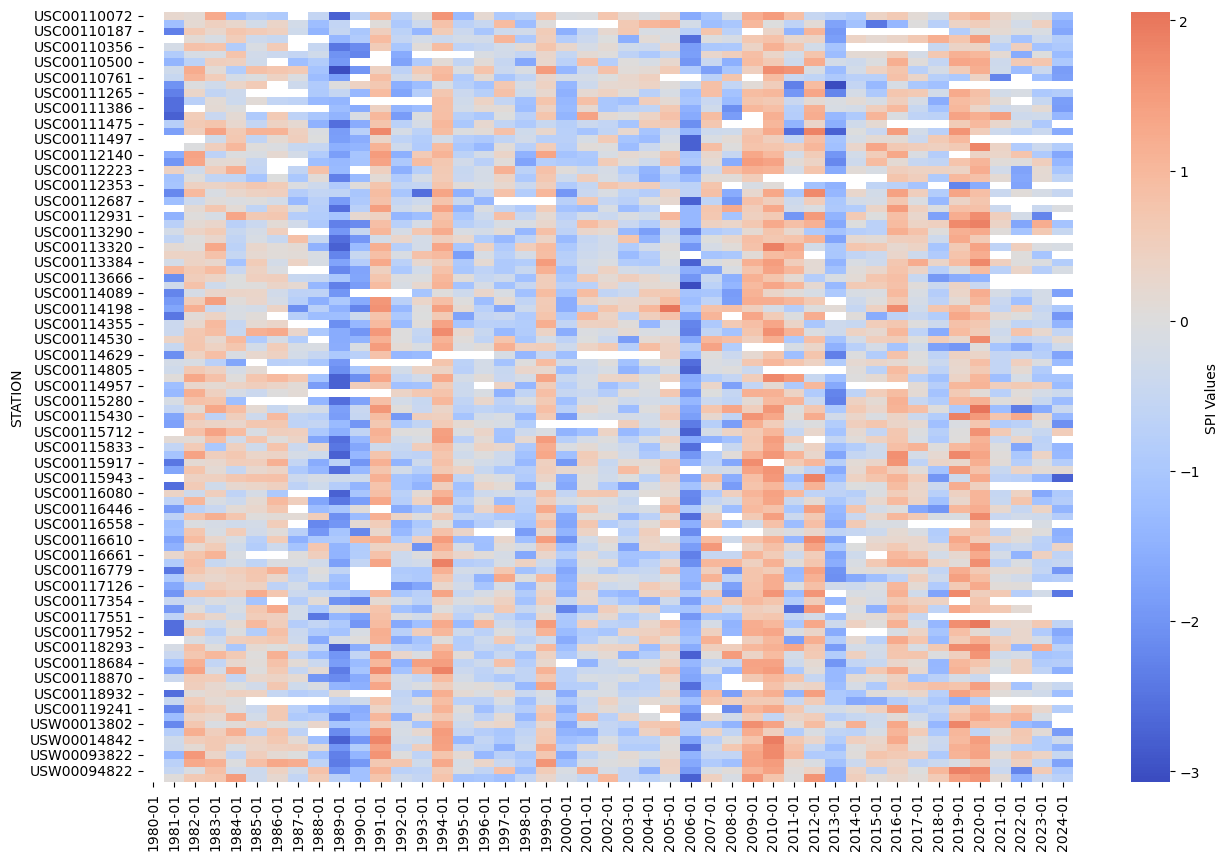

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

spi_df = pd.read_csv('SPI_M.csv')

# Select 100 stations 
sample_size = min(100, len(spi_df['STATION'].unique()))
selected_stations = np.random.choice(spi_df['STATION'].unique(), sample_size, replace=False)

# Get the range of years in the dataset and choose the first month of each year
all_years = pd.to_datetime(spi_df.columns[2:]).year
selected_dates = [f"{year:04d}-01" for year in range(min(all_years), max(all_years) + 1)]

# Create a dataframe with selected stations and dates
subset_df = spi_df.loc[spi_df['STATION'].isin(selected_stations), ['STATION'] + selected_dates]

# Set STATION as the index
subset_df.set_index('STATION', inplace=True)

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(subset_df, cmap='coolwarm', center=0, cbar_kws={'label': 'SPI Values', 'ticks': [-3, -2, -1, 0, 1, 2, 3]})

plt.show()


In [171]:
import pandas as pd

df = pd.read_csv('SPI_M.csv')

# Extract y-m columns
spi_columns = df.columns[2:]

# Calculate the average SPI across all stations
average_spi = df[spi_columns].mean()

average_spi.to_csv('AVG_SPI.csv')

print(average_spi)

1980-01         NaN
1980-02         NaN
1980-03         NaN
1980-04         NaN
1980-05         NaN
             ...   
2023-09   -0.877083
2023-10   -0.700075
2023-11   -0.837309
2023-12   -0.865164
2024-01   -1.078734
Length: 529, dtype: float64


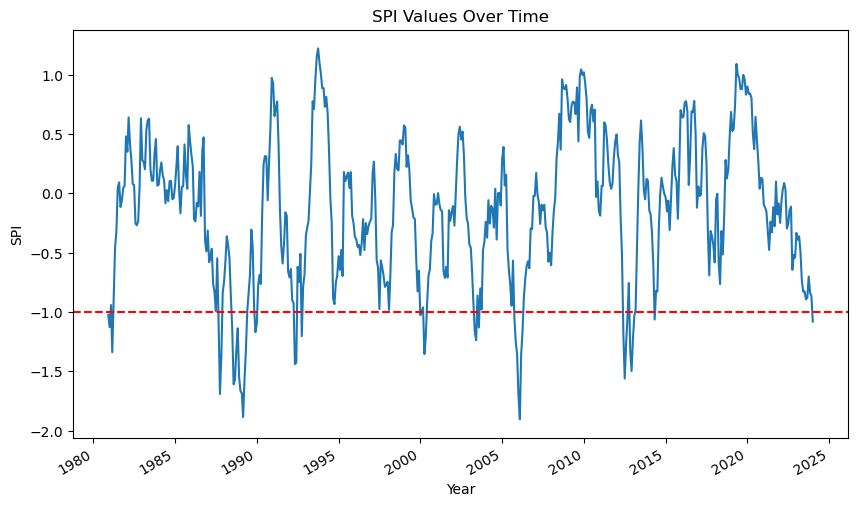

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load the file without headers
spi_data = pd.read_csv('AVG_SPI.csv', header=None, names=['Date', 'SPI'])

# Convert date column to datetime format
spi_data['Date'] = pd.to_datetime(spi_data['Date'], format='%Y-%m')

# Plot the SPI values
plt.figure(figsize=(10, 6))
plt.plot(spi_data['Date'], spi_data['SPI'], marker='', linestyle='-')
plt.axhline(y=-1, color='r', linestyle='--')

# Show dates in 5-year intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.xlabel('Year')
plt.ylabel('SPI')
plt.title('SPI Values Over Time')
plt.show()
